In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# testing

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5, 0.25) # set of x from -5 to 5 in steps of .25
xs

In [ ]:
ys = f(xs)
ys

In [ ]:
plt.plot(xs, ys)

In [ ]:
# derivative of y using definition of derivative
h = 0.000001
x = 3.0
(f(x+h) - f(x))/h

In [ ]:
# visualization of the two points f(x+h) and f(x) and a red line between them to show slope (derivative)
h_test = 0.01
x1 = x
y1 = f(x)
x2 = x+h_test
y2 = f(x+h_test)

plt.plot(xs, ys)
plt.plot([x1, x2], [y1, y2], 'ro-')
plt.xlim([2.98, 3.03])
plt.ylim([19.8, 20.3])
plt.show()

In [ ]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

In [ ]:
# kinda like above but instead of just adding h to the input, a specific input variable (a) is bumped to see how the slope (derivative) changes
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

# neural networks

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label='d'
e = c + d; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L'
L

## manual back propagation

In [ ]:
# manually backpropagating for understanding

print("children of d are: " + str(d._prev))
print("operation that created the value: " + d._op)

def test_grad():
  h = 0.0000001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  d = a * b; d.label='d'
  e = c + d; e.label='e'
  f = Value(-2.0, label='f')
  L = e * f; L.label='L'
  L1 = L.data

  # add h to the value to get the gradient for that node

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  d = a * b; d.label='d'
  e = c + d; e.label='e'
  f = Value(-2.0, label='f')
  L = e * f; L.label='L'
  L2 = L.data + h

  print((L2 - L1)/h)

test_grad()

# notes:
# when backpropagating, plus node's local derivatives are 1, therefore they kinda "route" the derivative to the next node

In [ ]:
L.grad = 1.0
f.grad = 4.0
e.grad = -2.0
d.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [123]:
from graphviz import Digraph

# graphviz for visualization

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

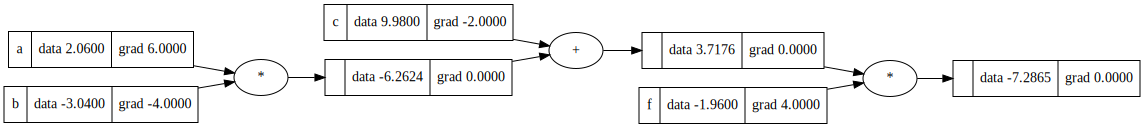

In [125]:
draw_dot(L)

# a- f are like weights, they affect the L (loss function kinda)

**manual back propagation:**

L.grad = dL / dL = 1

f.grad = dL / df = d(e * f) / df = { e * f^0 } = e = e.data = 4

e.grad = dL / de = d(e * f) / de = f = f.data = -2

c.grad = dL / dc = ( dL / de ) * ( de / dc ) = { using chain rule. we also know that dL / de = -2 from the above } = ( -2 ) * ( de / dc ) = { e = c+d } = ( -2 ) * ( d(c + d) / dc ) = -2 * 1 = -2

(note to remember chain rule: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man". so the car's speed relative to the bicycle relative to the walking man)

d.grad = dL / dd = ( dL / de ) * ( de / dd ) = ( -2 ) * ( d(d + c) / dd ) = -2 * 1 = -2

b.grad = dL / db = ( dL / dd ) * ( dd / db ) = { d = a*b } = ( -2 ) * ( d(a*b) / db ) = -2 * a = -2 * 2 = -4

a.grad = dL / da = ( dL / dd ) * ( dd / da ) = -2 * b = -2 * -3 = 6

In [ ]:
# test: nudging variables (positive direction) to make L go up
# only on leaf nodes

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a * b
e = c + d
L = e * f
L.data

### back progatagtion example 2 through a neuron

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# calculating the sum step by step
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
sum1 = x1w1x2w2 + b; sum1.label = 'sum1'
out = sum1.tanh(); out.label = 'out'

# sum1 to not disrupts python's sum() function :|

**manual back prop throuh tanh**

out = tanh(sum1)

d(out) / d(out) = 1

d(out) / d(sum1) = d(tanh(sum1)) / d(sum1) = 1 - tanh(sum1)^2 = 1 - o^2 = 0.5

d(out) / db = { local derivative is 1 for + signs, so the gradient is the same } = 0.5

d(out) / d(x1w1x2w2) = 0.5

d(out) / d(x1w1) = { plus sign again, so 0.5 keeps "flowing" down } = 0.5

d(out) / d(x2w2) = 0.5

d(out) / d(x1) = d(out) / d(x1w1) * d(x1w1) / d(x1) = ( 0.5 ) * ( w1.data ) = 0.5 * -3 = -1.5

d(out) / d(w1) = d(out) / d(x1w1) * d(x1w1) / d(w1) = ( 0.5 ) * ( 2 ) = 1

d(out) / d(x2) = d(out) / d(x2w2) * d(x2w2) / d(x2) = ( 0.5 ) * ( w2.data ) = 0.5 * 1 = 0.5

d(out) / d(w2) = { same process as above: chain rule then derivative of x2w2 with respect to w2 } = 0.5 * 0 = 0

*(note: grad > 0 means the output of the node is *positive* on the neuron's output)*

In [ ]:
out.grad = 1.0
sum1.grad = (1.0 - out.data**2)
b.grad = 0.5 # or (1.0 - out.data**2), same thing
x1w1x2w2.grad = 0.5
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [ ]:
#draw_dot(sum)
draw_dot(out)

## using backward function (instead of doing backprop manually lol)

In [127]:
# pasted again cause otherwise code below doesn't work

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# calculating the sum step by step
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
sum1 = x1w1x2w2 + b; sum1.label = 'sum1'
out = sum1.tanh(); out.label = 'out'

In [128]:
# (!) running the cell multiple times will compound the grads because of +=
# also, ._backward is the local backpropagation, it doesn't backprop through the entire nn yet

out.grad = 1.0 # set to 1.0 because grad is initialized to 0 and that would make all grads 0 when going backward cause of multiplication

out._backward()
sum1._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()

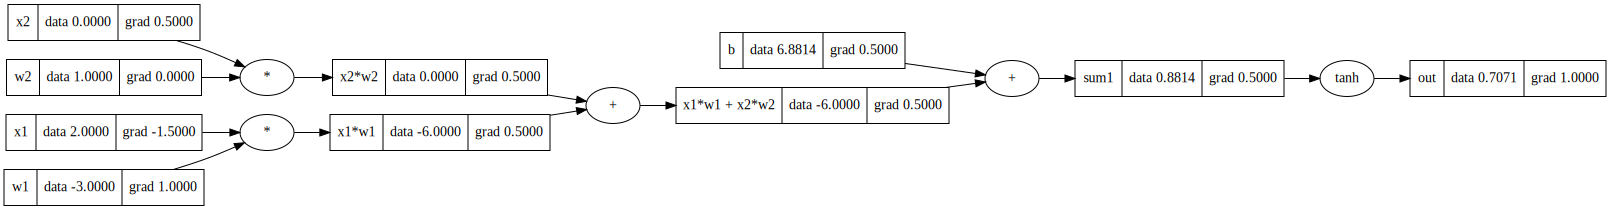

In [129]:
draw_dot(out)

In [ ]:
# using topological sort to not call _backward() manually for every node
out.backward()

In [ ]:
test1 = Value(3.0, label='test1')
test2 = test1 + test1; test2.label='test2'
test2.backward()
draw_dot(test2)
# gives test1.grad = 2 instead of 1 because of the += in the addition method

# using pytorch

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

In [ ]:
torch.Tensor([[2.0, 5.0], [4.0, 3.0]])

## building a neural net

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):

    #print(list(zip(self.w, x))) #  show how they're paired

    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # multiply all x's (inputs) with w's (weights) pair wise
    # activation function
    out = act.tanh() # non-linearity
    return out

  def parameters(self):
    return self.w + [self.b]

# a list of neurons with nout number of neurons in it (the layer)
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params
    # or ↓
    # return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  # nouts is the size of the layers in the MLP (takes a list of neurons that defines every layer)
  def __init__(self, nin, nouts):
    sz = [nin] + nouts # combined list that is the full nn representation ( [3] + [4, 4, 1] = [3, 4, 4, 1] in this case)
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # creates a layer object at each index with sz[i] inputs and sz[i+1] outputs.

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
# initializing the neural net

x = [2.0, 3.0, -1]
#x = [Value(2.0, label='x1'), Value(3.0, label='x2'), Value(-1.0, label='x3')]

#n = Neuron(2)
#n = Layer(2, 3)
n = MLP(3, [4, 4, 1])
n(x)

In [ ]:
draw_dot(n(x))

In [ ]:
# example dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
ypred = [n(x) for x in xs]
ypred

In [ ]:
# mean squared error loss to minimize loss
# gt = ground truth
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

In [ ]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
# this is the number we want to minimize
loss

In [ ]:
#recalculate loss
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

In [ ]:
ypred

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w

In [ ]:
n.layers[0].neurons[0].w[1].grad
# if number < 0 = its influence on the loss is negative, so increasing this weight would make the loss go down

In [ ]:
n.layers[0].neurons[0].w[1].data

In [ ]:
print(n.parameters())
len(n.parameters())

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad

## the gradient descent loop

In [ ]:
#recalculate loss
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

In [ ]:
loss.backward()

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
ypred

In [ ]:
ypred

In [ ]:
loss

In [ ]:
n.parameters()

an actual training loop instead of doing it manually lol

In [ ]:
for k in range(50):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
  loss

  # backward pass (with zero-grad before backward pass!!)
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss, loss.data)

## what the neural network looks like hehe

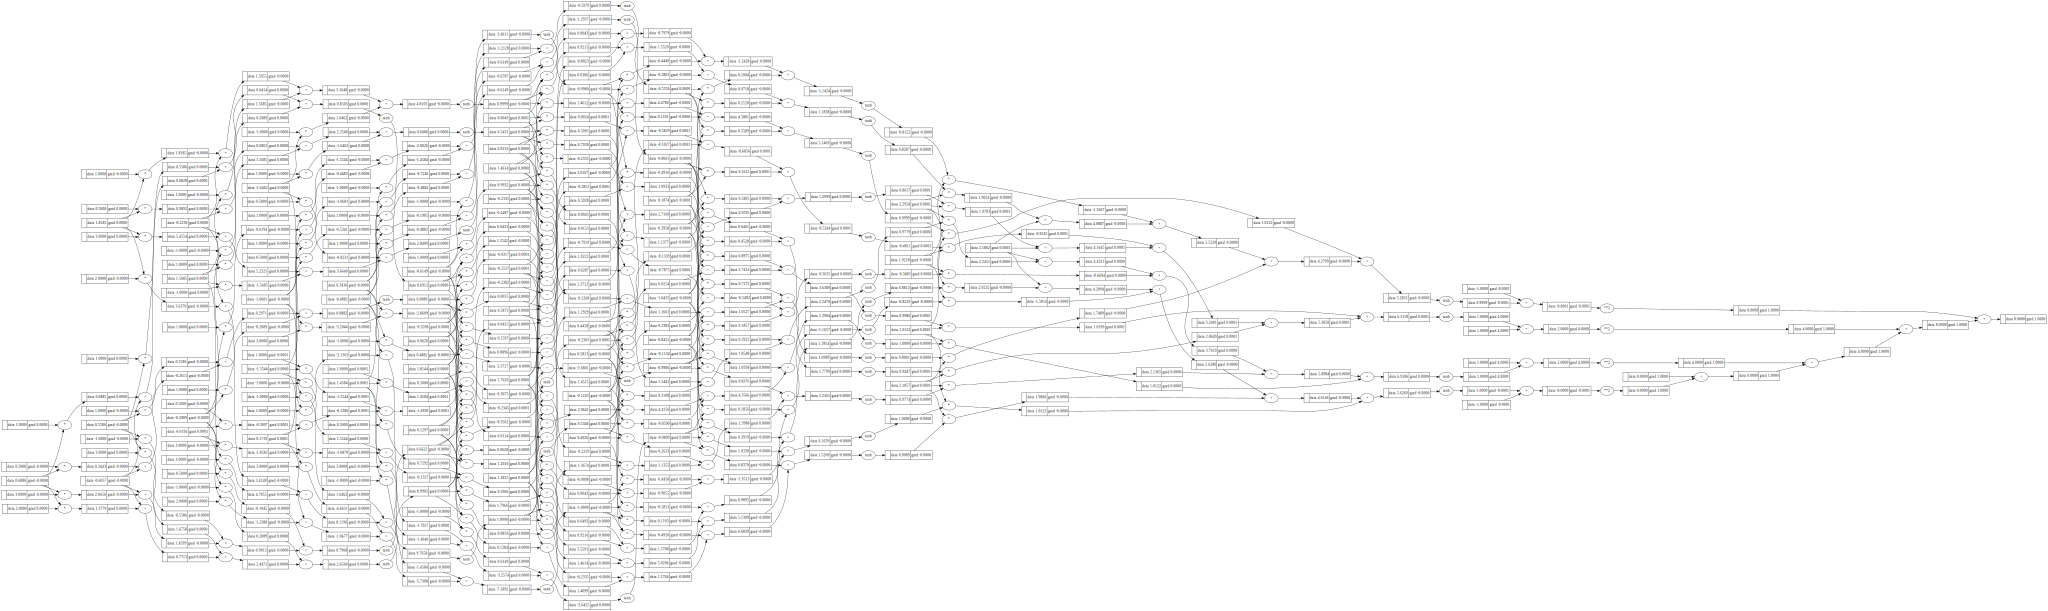

In [130]:
draw_dot(loss)